In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from tabulate import tabulate
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix



In [8]:
!pip install tabulate

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist")

In [9]:
train_csv = pd.read_csv("/home/asus/Desktop/Office/FashionDataset/fashion-mnist_train.csv")
test_csv = pd.read_csv("/home/asus/Desktop/Office/FashionDataset/fashion-mnist_test.csv")

In [10]:
class FashionDataset(Dataset):

    
    def __init__(self, data, transform = None):

        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
            
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)


In [11]:
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [12]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [13]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [14]:
len(train_set)

60000

2


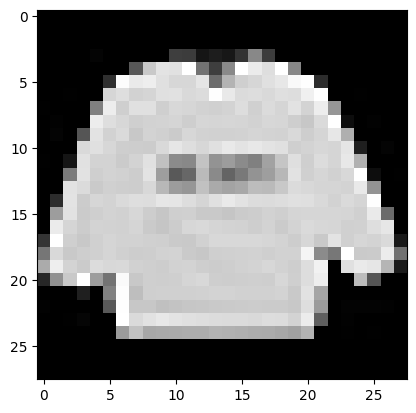

In [15]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [80]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


In [16]:
grid = torchvision.utils.make_grid(images, nrow=4)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

NameError: name 'images' is not defined

In [13]:
img_grid = torchvision.utils.make_grid(images)
writer.add_image("mnist_images", img_grid)
writer.close()

In [14]:
%load_ext tensorboard
%tensorboard --logdir runs

In [16]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
             nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [17]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [23]:
class LeNet5(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.features = torch.nn.Sequential(
        
            nn.Conv2d(1, 6, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2)
        
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*4*4, 120),
            torch.nn.Linear(120, 84),
            torch.nn.Linear(84, 10)
        
        ) 
        
    def forward(self,x):
        x= self.features(x) 
        x= torch.flatten(x,1)
        logits = self.classifier(x)
        

In [24]:
model = LeNet5()
model.to(device)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(model)


LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [25]:
model = LeNet5()

layers = [
    ["Layer", "Input Shape", "Output Shape"],
    ["Conv1", "1x28x28", "6x24x24"],
    ["MaxPool1", "6x24x24", "6x12x12"],
    ["Conv2", "6x12x12", "16x8x8"],
    ["MaxPool2", "16x8x8", "16x4x4"],
    ["Flatten", "16x4x4", "256"],
    ["FC1", "256", "120"],
    ["FC2", "120", "84"],
    ["FC3", "84", "10"],
]

table = tabulate(layers, headers="firstrow", tablefmt="grid")
print(table)

+----------+---------------+----------------+
| Layer    | Input Shape   | Output Shape   |
+==========+===============+================+
| Conv1    | 1x28x28       | 6x24x24        |
+----------+---------------+----------------+
| MaxPool1 | 6x24x24       | 6x12x12        |
+----------+---------------+----------------+
| Conv2    | 6x12x12       | 16x8x8         |
+----------+---------------+----------------+
| MaxPool2 | 16x8x8        | 16x4x4         |
+----------+---------------+----------------+
| Flatten  | 16x4x4        | 256            |
+----------+---------------+----------------+
| FC1      | 256           | 120            |
+----------+---------------+----------------+
| FC2      | 120           | 84             |
+----------+---------------+----------------+
| FC3      | 84            | 10             |
+----------+---------------+----------------+


In [89]:
writer.add_graph(model, images)
writer.close

mat1 and mat2 shapes cannot be multiplied (64x256 and 400x120)
Error occurs, No graph saved


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x256 and 400x120)

In [18]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 11147), started 0:00:00 ago. (Use '!kill 11147' to kill it.)

In [39]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
  
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
      
        outputs, x = model1(images)
        loss = criterion(output, labels)
        
       
        optimizer.zero_grad()
        
     
        loss.backward()
     
        optimizer.step()
    
        count += 1
    

    
        if not (count % 50):    
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

TypeError: cannot unpack non-iterable NoneType object

In [107]:
x = torch.randn(100, 1, 28, 28)  
resized_x = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)
print(resized_x.shape)

torch.Size([100, 1, 32, 32])


In [161]:
resize_transform = torchvision.transforms.Compose([
     transforms.ToPILImage(),
     torchvision.transforms.Resize((32,32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5),(0.5,))])

input_image = torch.randn(1, 28, 28)
print(image.shape)

resized_image = resize_transform(input_image)

print(resized_image.shape)



torch.Size([1, 28, 28])
torch.Size([1, 32, 32])


In [235]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for resized_image, labels in train_loader:
        resized_image, labels = resized_image.to(device), labels.to(device)
        print(train.shape)
        train = Variable(resized_image.view(100, 1, 28, 28))
        labels = Variable(labels)
        

        output = model1(train)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += 1

        if not (count % 50):    
            total = 0
            correct = 0

            for resized_image, labels in test_loader:
                resized_image, labels = resized_image.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(resized_image.view(100, 1, 28, 28))
                outputs = model1(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

torch.Size([100, 1, 28, 28])


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not NoneType

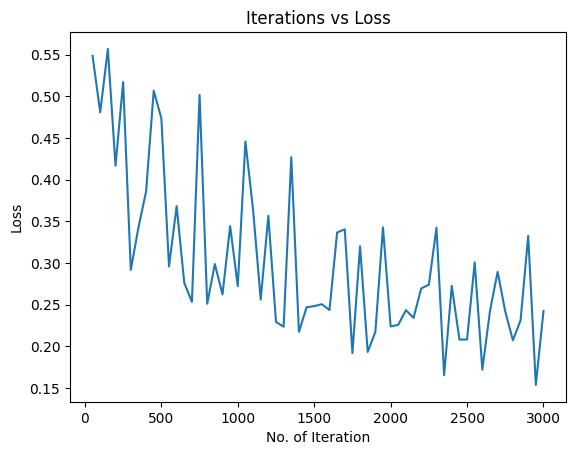

In [20]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [30]:
for epoch in range(5):
    total_train_loss = 0.0
    total_test_loss = 0.0
    
    print("Epoch:", epoch)
    model.train()
    
    total = 0
    for idx,(image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        
        pred = model(image)
        loss=criterion(pred, label)
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        pred = torch.nn.functional.softmax(pred,dim=1)
        
        for i,p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total=total+1
                
        total_train_acc = total / len(train_set)
        total_train_loss = total_train_loss / (idx + 1)
        
        total = 0
        model.eval()
    for idx,(image, label) in enumerate(test_loader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss=criterion(pred, label)
        total_test_loss += loss.item()
        pred = torch.nn.functional.softmax(pred,dim=1)
                    
        for i,p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total=total+1 

                total_test_acc = total/ len(test_set) 
                total_test_loss = total_test_loss / (idx + 1)
                
                    

    #if epoch %2==0:
        writer.add_scalar('Loss/Training',total_train_loss,epoch)
        writer.add_scalar('Loss/Testing',total_test_loss,epoch)
        writer.add_scalar('Accuracy/Training',total_train_acc,epoch)
        writer.add_scalar('Accuracy/Testing',total_test_acc,epoch)
        print("Epoch: ", epoch)

Epoch: 0


RuntimeError: The size of tensor a (10) must match the size of tensor b (100) at non-singleton dimension 1

In [22]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 11147), started 0:53:05 ago. (Use '!kill 11147' to kill it.)

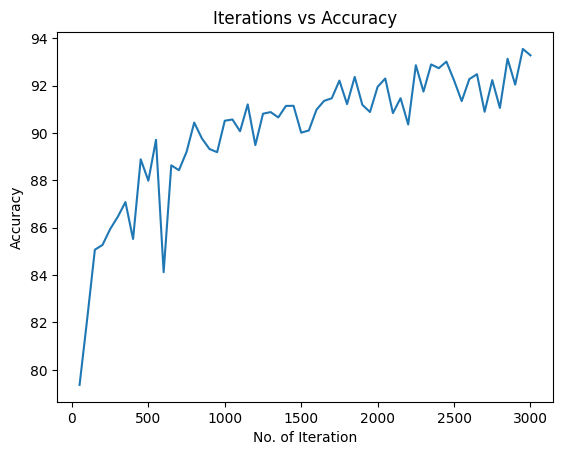

In [23]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [24]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 94.72%
Accuracy of Trouser: 99.57%
Accuracy of Pullover: 92.25%
Accuracy of Dress: 98.47%
Accuracy of Coat: 93.65%
Accuracy of Sandal: 99.20%
Accuracy of Shirt: 73.05%
Accuracy of Sneaker: 97.22%
Accuracy of Bag: 98.20%
Accuracy of Ankle Boot: 99.45%
